### Load Data

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, models, transforms

from tqdm import tqdm

In [2]:
train_dataset = datasets.MNIST(root = '.\data', train = True, download = True)
test_dataset = datasets.MNIST(root = '.\data', train = False, download = True)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Admin\AppData\Local\Temp\ipykernel_11504\3635372030.py:1: SyntaxWarning: invalid escape sequence '\d'
  train_dataset = datasets.MNIST(root = '.\data', train = True, download = True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11504\3635372030.py:2: SyntaxWarning: invalid escape sequence '\d'
  test_dataset = datasets.MNIST(root = '.\data', train = False, download = True)
100%|██████████| 9.91M/9.91M [01:01<00:00, 161kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 105kB/s]
100%|██████████| 1.65M/1.65M [00:03<00:00, 439kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.36MB/s]


In [9]:
def mnist_to_dataframe(dataset):
    images = []
    labels = []
    for img, label in dataset: 
        img_array = np.array(img) #PIL Image -> numpy array
        img_flat = img_array.flatten()
        images.append(img_flat)
        labels.append(label)
    df = pd.DataFrame(images)
    df['label'] = labels
    return df

train_df = mnist_to_dataframe(train_dataset)
test_df = mnist_to_dataframe(test_dataset)

display(train_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
59996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
59997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
59998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    # 255 to 0 -> 1 scale. x_train = (x_train / 255.0).values
    transforms.Normalize((0.5,), (0.5,))
    # normalize to mean=0.5, std=0.5 -> range [-1, 1]
])

train_dataset = datasets.MNIST(root = '.\data', train = True, download = False, transform = transform)
test_dataset = datasets.MNIST(root = '.\data', train = False, download = False, transform = transform)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Admin\AppData\Local\Temp\ipykernel_11504\4097861936.py:8: SyntaxWarning: invalid escape sequence '\d'
  train_dataset = datasets.MNIST(root = '.\data', train = True, download = False, transform = transform)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11504\4097861936.py:9: SyntaxWarning: invalid escape sequence '\d'
  test_dataset = datasets.MNIST(root = '.\data', train = False, download = False, transform = transform)


In [15]:
dataiter = iter(train_loader)
data = next(dataiter)
features, labels = data
print(features, labels)

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

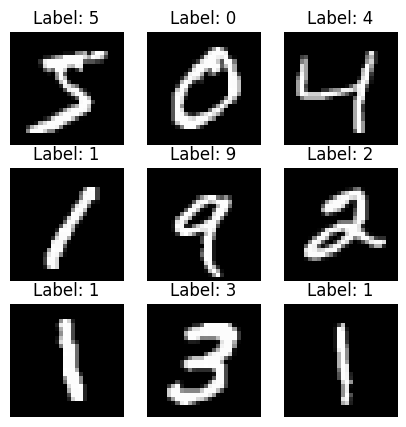

In [17]:
plt.figure(figsize = (5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    
    img = train_df.iloc[i, :-1].values.reshape(28, 28)
    label = train_df.iloc[i, -1]

    plt.imshow(img, cmap = 'gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.show()
    

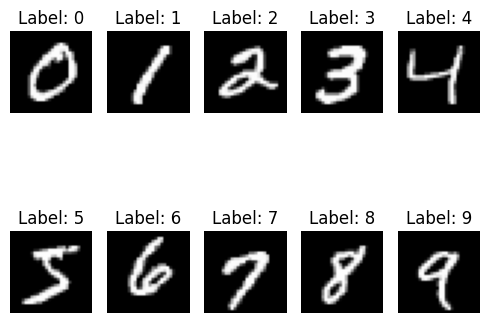

In [22]:
def visualize_each_class():
    samples = {}
    for img, label in train_dataset:
        if label not in samples:
            samples[label] = img
        if len(samples) == 10: 
            break
    
    fig = plt.figure(figsize = (5, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1) # ✅ 2 hàng × 5 cột = 10 ô
        plt.imshow(samples[i].squeeze(), cmap = 'gray') #Bỏ đi chiều 1 dư thừa, để imshow() có thể hiểu và hiển thị ảnh đúng
        plt.title(f'Label: {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_each_class()

### ML Algorithms

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier, StackingClassifier

In [20]:
x_train_df = train_df.drop('label', axis = 1)
y_train_df = train_df['label']
x_test_df = test_df.drop('label', axis = 1)
y_test_df = test_df['label']

In [26]:
model = RandomForestClassifier()
model.fit(x_train_df, y_train_df)
y_pred = model.predict(x_test_df)

print(classification_report(y_test_df, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9729    0.9898    0.9813       980
           1     0.9877    0.9877    0.9877      1135
           2     0.9614    0.9651    0.9632      1032
           3     0.9633    0.9614    0.9623      1010
           4     0.9734    0.9695    0.9714       982
           5     0.9739    0.9619    0.9679       892
           6     0.9731    0.9812    0.9771       958
           7     0.9686    0.9611    0.9648      1028
           8     0.9558    0.9548    0.9553       974
           9     0.9543    0.9514    0.9529      1009

    accuracy                         0.9686     10000
   macro avg     0.9684    0.9684    0.9684     10000
weighted avg     0.9686    0.9686    0.9686     10000



In [28]:
#Bagging
base_model = DecisionTreeClassifier()
bagging = BaggingClassifier(
    estimator = base_model, 
    n_estimators = 10, #so luong mo hinh con
    max_samples = 0.8, #train tren 80% du lieu, co hoan lai
    random_state = 42
)
bagging.fit(x_train_df, y_train_df)
y_pred = bagging.predict(x_test_df)

print(classification_report(y_test_df, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9342    0.9857    0.9593       980
           1     0.9620    0.9824    0.9721      1135
           2     0.9215    0.9438    0.9325      1032
           3     0.9109    0.9109    0.9109      1010
           4     0.9376    0.9328    0.9352       982
           5     0.9132    0.8969    0.9050       892
           6     0.9504    0.9405    0.9454       958
           7     0.9526    0.9377    0.9451      1028
           8     0.9348    0.8973    0.9157       974
           9     0.9365    0.9207    0.9285      1009

    accuracy                         0.9359     10000
   macro avg     0.9354    0.9349    0.9350     10000
weighted avg     0.9359    0.9359    0.9357     10000



In [31]:
#Boosting
base_model = DecisionTreeClassifier()
boosting = AdaBoostClassifier(
    estimator = base_model,
    n_estimators = 50,
    learning_rate = 0.5,
    random_state = 42
)

boosting.fit(x_train_df, y_train_df)
y_pred = boosting.predict(x_test_df)    

print(classification_report(y_test_df, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9116    0.9367    0.9240       980
           1     0.9552    0.9577    0.9564      1135
           2     0.8801    0.8537    0.8667      1032
           3     0.8251    0.8594    0.8419      1010
           4     0.8794    0.8686    0.8740       982
           5     0.8263    0.8318    0.8291       892
           6     0.8940    0.8800    0.8869       958
           7     0.9125    0.8930    0.9027      1028
           8     0.8166    0.8090    0.8128       974
           9     0.8451    0.8543    0.8497      1009

    accuracy                         0.8760     10000
   macro avg     0.8746    0.8744    0.8744     10000
weighted avg     0.8762    0.8760    0.8760     10000



In [33]:
#Stacking
base_model = [
    ('dt', DecisionTreeClassifier()),
    ('svm', SVC(probability = True))
]

meta_model = LogisticRegression()

stacking = StackingClassifier(
    estimators = base_model, 
    final_estimator = meta_model
)

stacking.fit(x_train_df, y_train_df)
y_pred = stacking.predict(x_test_df)

print(classification_report(y_test_df, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9808    0.9918    0.9863       980
           1     0.9903    0.9921    0.9912      1135
           2     0.9768    0.9777    0.9772      1032
           3     0.9756    0.9881    0.9818      1010
           4     0.9836    0.9766    0.9801       982
           5     0.9831    0.9776    0.9803       892
           6     0.9884    0.9802    0.9843       958
           7     0.9728    0.9747    0.9738      1028
           8     0.9753    0.9743    0.9748       974
           9     0.9720    0.9643    0.9682      1009

    accuracy                         0.9799     10000
   macro avg     0.9799    0.9797    0.9798     10000
weighted avg     0.9799    0.9799    0.9799     10000



In [34]:
#Voting
voting = VotingClassifier(
    estimators = [
        ('lr', LogisticRegression()),
        ('dt', DecisionTreeClassifier()),
        ('svm', SVC(probability = True))
    ],
    voting = 'hard' #'soft' for probabilities
)

voting.fit(x_train_df, y_train_df)  
y_pred = voting.predict(x_test_df)

print(classification_report(y_test_df, y_pred, digits = 4))

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0     0.9558    0.9918    0.9735       980
           1     0.9757    0.9903    0.9829      1135
           2     0.9350    0.9612    0.9479      1032
           3     0.9390    0.9604    0.9496      1010
           4     0.9632    0.9593    0.9612       982
           5     0.9679    0.9473    0.9575       892
           6     0.9759    0.9729    0.9744       958
           7     0.9711    0.9484    0.9596      1028
           8     0.9560    0.9363    0.9461       974
           9     0.9661    0.9316    0.9485      1009

    accuracy                         0.9604     10000
   macro avg     0.9606    0.9600    0.9601     10000
weighted avg     0.9606    0.9604    0.9604     10000



Accuracy Score<br>
__________________________________________________
Logistic Regression: 0.9255  
Decision Tree: 0.8774  
Random Forest: 0.9686  
Bagging: 0.9359  
Boosting: 0.8760  
Stacking: 0.9799  
Voting: 0.9604

### DNN Basic

In [ ]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = DNN()

In [49]:
learning_rate = 0.001
num_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [50]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if(i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{n_total_steps}], Loss: {loss.item():.4f}')


Epoch [1/20], Step [100/938], Loss: 0.2874
Epoch [1/20], Step [200/938], Loss: 0.0990
Epoch [1/20], Step [300/938], Loss: 0.1184
Epoch [1/20], Step [400/938], Loss: 0.0901
Epoch [1/20], Step [500/938], Loss: 0.1333
Epoch [1/20], Step [600/938], Loss: 0.1350
Epoch [1/20], Step [700/938], Loss: 0.1540
Epoch [1/20], Step [800/938], Loss: 0.1535
Epoch [1/20], Step [900/938], Loss: 0.1031
Epoch [2/20], Step [100/938], Loss: 0.0950
Epoch [2/20], Step [200/938], Loss: 0.1912
Epoch [2/20], Step [300/938], Loss: 0.1474
Epoch [2/20], Step [400/938], Loss: 0.0580
Epoch [2/20], Step [500/938], Loss: 0.1914
Epoch [2/20], Step [600/938], Loss: 0.3286
Epoch [2/20], Step [700/938], Loss: 0.0866
Epoch [2/20], Step [800/938], Loss: 0.2611
Epoch [2/20], Step [900/938], Loss: 0.1347
Epoch [3/20], Step [100/938], Loss: 0.3262
Epoch [3/20], Step [200/938], Loss: 0.1728
Epoch [3/20], Step [300/938], Loss: 0.1708
Epoch [3/20], Step [400/938], Loss: 0.2001
Epoch [3/20], Step [500/938], Loss: 0.1730
Epoch [3/20

In [52]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    all_preds = []
    all_labels = []

    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) #vì max trả về cả index

        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

acc = 100.0 * n_correct / n_samples
print(f"Accuracy_Score: {acc:.2f} %")

precision = precision_score(all_labels, all_preds, average = 'macro')
recall = recall_score(all_labels, all_preds, average = 'macro')
f1 = f1_score(all_labels, all_preds, average = 'macro')

print(f'🎯 Precision: {precision:.4f}')
print(f'🔁 Recall:    {recall:.4f}')
print(f'📏 F1 Score:  {f1:.4f}')

# Báo cáo chi tiết theo từng lớp
print("\n📊 Classification report:")
print(classification_report(all_labels, all_preds))

Accuracy_Score: 95.23 %
🎯 Precision: 0.9519
🔁 Recall:    0.9517
📏 F1 Score:  0.9517

📊 Classification report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.95      0.96      1032
           3       0.94      0.95      0.94      1010
           4       0.94      0.96      0.95       982
           5       0.95      0.93      0.94       892
           6       0.95      0.96      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.93      0.93      0.93       974
           9       0.94      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



### DNN Optimization

In [85]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [76]:
class DNN_Optim(nn.Module):
    def __init__(self):
        super(DNN_Optim, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.drop = nn.Dropout(p = 0.2)
    
    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.drop(x)
        x = torch.relu(self.fc3(x))
        x = self.drop(x)
        x = self.fc4(x)
        return x
    
model = DNN_Optim()

In [77]:
class EarlyStopping:
    def __init__(self, patience=20, delta=0.0):
        self.patience = patience # Dừng nếu không cải thiện sau n epoch
        self.delta = delta       # Ngưỡng cải thiện tối thiểu
        self.best = None         # điểm tốt nhất đã thấy (ở đây là -val_loss)
        self.counter = 0         # đếm số epoch liên tiếp không cải thiện
        self.early_stop = False  
        self.best_state = None   # state_dict tốt nhất để khôi phục

    def __call__(self, val_loss, model):
        score = -val_loss  # minimize loss
        if self.best is None or score > self.best + self.delta:
            self.best = score
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()} # copy từng tensor của state_dict sang CPU
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [92]:
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-3)
early_stop = EarlyStopping()
lr_schedule = ReduceLROnPlateau(
    optimizer = optimizer,
    mode = 'min',  #Min để theo dõi loss, max để theo dõi accuracy
    factor = 0.5, #Giảm LR còn 50% khi không cải thiện
    patience = 5, #Giảm LR nếu không cải thiện sau 5 epoch
    min_lr = 1e-5 #Giá trị LR tối thiểu
)

In [ ]:
val_ratio = 0.2
n_val = int(len(train_dataset) * val_ratio)
n_train = len(train_dataset) - n_val
train_ds, val_ds = random_split(train_dataset, [n_train, n_val])

train_loader= DataLoader(train_ds, batch_size = 64, shuffle = True) #750
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)     #188
test_loader= DataLoader(test_dataset, batch_size=64, shuffle=False)

In [94]:
for epoch in range(num_epochs):
    #--- Train ---
    model.train() #Bật dropout
    running_loss = 0.0
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0) # Nhân với batch_size vì Loss của batch là trung bình loss trên 64 mẫu. Cần nhân lại để khôi phục loss thật
    train_loss = running_loss / len(train_loader.dataset)

    #--- Validate ---
    model.eval() #Tắt Dropout. Để kết quả không bị ngẫu nhiên thay đổi mỗi lần chạy
    val_running = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_running += loss.item() * labels.size(0)
    val_loss = val_running / len(val_loader.dataset)
    
    #--- Scheduler & EarlyStopping --- 
    lr_schedule.step(val_loss)
    early_stop(val_loss, model)
    print(f"Epoch {epoch+1:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | lr={optimizer.param_groups[0]['lr']:.6f}")

    if early_stop.early_stop: 
        print("Early stopping triggered. Restoring best weights...")
        model.load_state_dict(early_stop.best_state)
        break


Epoch 001 | train_loss=2.2053 | val_loss=2.1570 | lr=0.001000
Epoch 002 | train_loss=2.1163 | val_loss=2.0325 | lr=0.001000
Epoch 003 | train_loss=1.9649 | val_loss=1.8266 | lr=0.001000
Epoch 004 | train_loss=1.7387 | val_loss=1.5394 | lr=0.001000
Epoch 005 | train_loss=1.4735 | val_loss=1.2525 | lr=0.001000
Epoch 006 | train_loss=1.2526 | val_loss=1.0493 | lr=0.001000
Epoch 007 | train_loss=1.0984 | val_loss=0.9117 | lr=0.001000
Epoch 008 | train_loss=0.9864 | val_loss=0.8088 | lr=0.001000
Epoch 009 | train_loss=0.8977 | val_loss=0.7248 | lr=0.001000
Epoch 010 | train_loss=0.8227 | val_loss=0.6605 | lr=0.001000
Epoch 011 | train_loss=0.7606 | val_loss=0.6078 | lr=0.001000
Epoch 012 | train_loss=0.7114 | val_loss=0.5671 | lr=0.001000
Epoch 013 | train_loss=0.6694 | val_loss=0.5337 | lr=0.001000
Epoch 014 | train_loss=0.6351 | val_loss=0.5063 | lr=0.001000
Epoch 015 | train_loss=0.6068 | val_loss=0.4833 | lr=0.001000
Epoch 016 | train_loss=0.5827 | val_loss=0.4636 | lr=0.001000
Epoch 01

In [95]:
model.eval()
n_samples = n_correct = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * n_correct/ n_samples:.2f}%')

Accuracy: 94.70%


### CNN

In [121]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    # 255 to 0 -> 1 scale. x_train = (x_train / 255.0).values
    transforms.Normalize((0.5,), (0.5,))
    # normalize to mean=0.5, std=0.5 -> range [-1, 1]
])

train_dataset = datasets.MNIST(root = '.\data', train = True, download = False, transform = transform)
test_dataset = datasets.MNIST(root = '.\data', train = False, download = False, transform = transform)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Admin\AppData\Local\Temp\ipykernel_11504\4097861936.py:8: SyntaxWarning: invalid escape sequence '\d'
  train_dataset = datasets.MNIST(root = '.\data', train = True, download = False, transform = transform)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11504\4097861936.py:9: SyntaxWarning: invalid escape sequence '\d'
  test_dataset = datasets.MNIST(root = '.\data', train = False, download = False, transform = transform)


In [123]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [129]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

In [ ]:
def Training(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        n_samples = 0 
        n_correct = 0

        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            #predicted = outputs.argmax(1)  
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset) # hoặc len(train_dataset)
        train_acc = 100.0 * n_correct / n_samples
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        #--- Test ---
        model.eval()
        test_loss = 0.0
        n_samples = 0 
        n_correct = 0

        with torch.no_grad():
            for images, labels in test_loader: 
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = 100.0 * n_correct / n_samples
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}")
            
    return train_losses, train_accs, test_losses, test_accs
    
(train_losses_cnn, 
 train_accs_cnn,
 test_losses_cnn, 
 test_accs_cnn) = Training(cnn, train_loader, test_loader, criterion, optimizer, num_epochs)


Epoch 1/10: Train Loss: 0.0064, Train Acc: 99.78, Test Loss: 0.0349, Test Acc: 99.26
Epoch 2/10: Train Loss: 0.0071, Train Acc: 99.78, Test Loss: 0.0440, Test Acc: 99.17
Epoch 3/10: Train Loss: 0.0042, Train Acc: 99.86, Test Loss: 0.0413, Test Acc: 99.17
Epoch 4/10: Train Loss: 0.0049, Train Acc: 99.84, Test Loss: 0.0339, Test Acc: 99.30
Epoch 5/10: Train Loss: 0.0055, Train Acc: 99.83, Test Loss: 0.0437, Test Acc: 99.19
Epoch 6/10: Train Loss: 0.0043, Train Acc: 99.85, Test Loss: 0.0354, Test Acc: 99.31
Epoch 7/10: Train Loss: 0.0054, Train Acc: 99.80, Test Loss: 0.0457, Test Acc: 99.18
Epoch 8/10: Train Loss: 0.0054, Train Acc: 99.84, Test Loss: 0.0366, Test Acc: 99.24
Epoch 9/10: Train Loss: 0.0042, Train Acc: 99.87, Test Loss: 0.0366, Test Acc: 99.18
Epoch 10/10: Train Loss: 0.0021, Train Acc: 99.93, Test Loss: 0.0373, Test Acc: 99.27


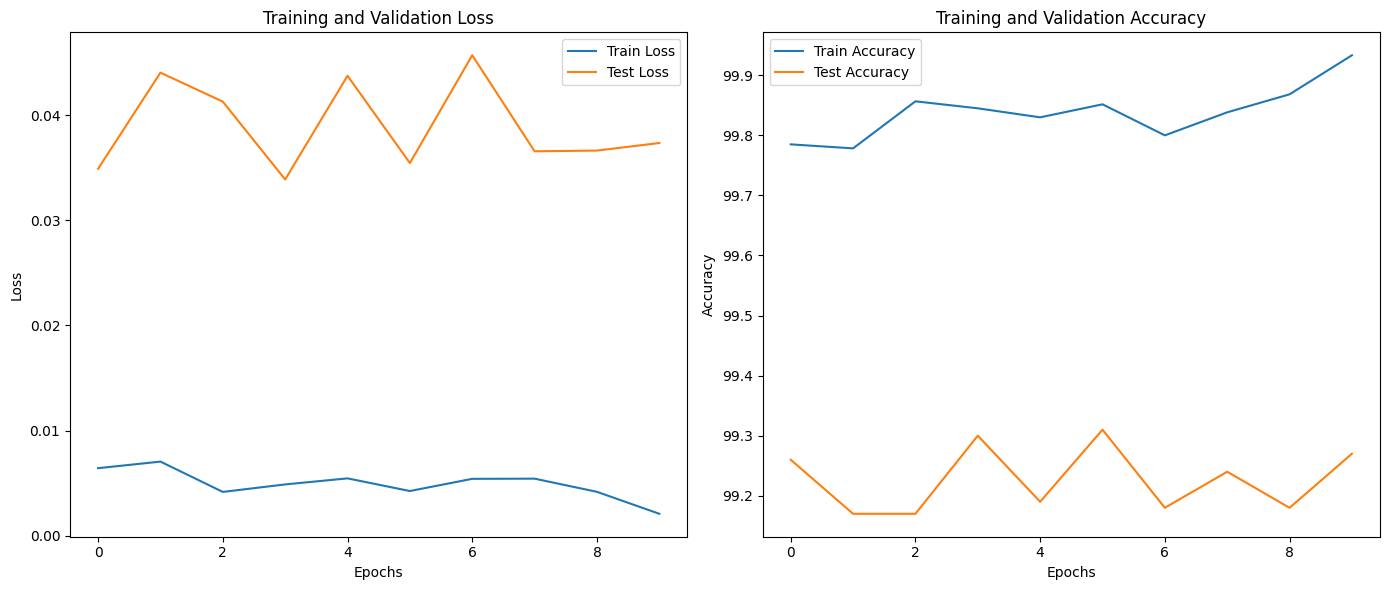

In [ ]:
def Line_Graph(train_losses, train_accs, test_losses, test_accs):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

Line_Graph(train_losses_cnn, train_accs_cnn, test_losses_cnn, test_accs_cnn)

              precision    recall  f1-score   support

           0     0.9959    0.9969    0.9964       980
           1     0.9930    1.0000    0.9965      1135
           2     0.9932    0.9893    0.9913      1032
           3     0.9950    0.9921    0.9936      1010
           4     0.9899    0.9959    0.9929       982
           5     0.9933    0.9922    0.9927       892
           6     0.9958    0.9927    0.9942       958
           7     0.9855    0.9912    0.9884      1028
           8     0.9908    0.9918    0.9913       974
           9     0.9950    0.9841    0.9895      1009

    accuracy                         0.9927     10000
   macro avg     0.9927    0.9926    0.9927     10000
weighted avg     0.9927    0.9927    0.9927     10000



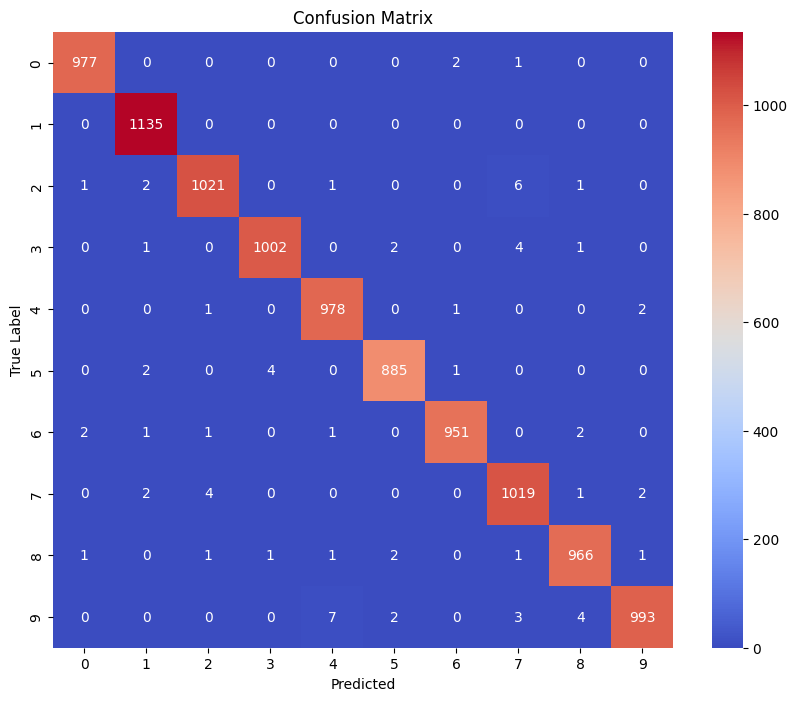

In [135]:
def Evaluate(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    print(classification_report(y_true, y_pred, digits = 4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (10, 8))
    sns.heatmap(cm, 
                annot = True, 
                fmt = 'd',                # Định dạng số trong từng ô
                cmap = 'coolwarm',
                xticklabels = range(10),  #Đặt nhãn cho trục x
                yticklabels = range(10))  #Đặt nhãn cho trục y
    plt.xlabel('Predicted')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Evaluate(cnn, test_loader)

In [ ]:
def visualize_tsne(model, data_loader, num_samples = 1000):
    model.eval()
    features = labels = []

    with torch.no_grad():
        for image, label in data_loader:
            outputs = model(image)
            features.append(outputs.numpy())
            labels.extend(label.numpy())

            if len(labels) >= num_samples:
                break   
    
    features = np.vstack(features)[:num_samples] #Ghép tất cả các mảng 2D trong list theo trục dọc
    labels = np.array(labels)[:num_samples]

    tsne = TSNE(n_components = 2, 
                perplexity = 30,       #effective number of neighbors 
                random_state = 42)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize = (10, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette='tab10', alpha=0.75)
    plt.title('t-SNE Visualization of Model Features')
    plt.show()

visualize_tsne(cnn, test_loader)

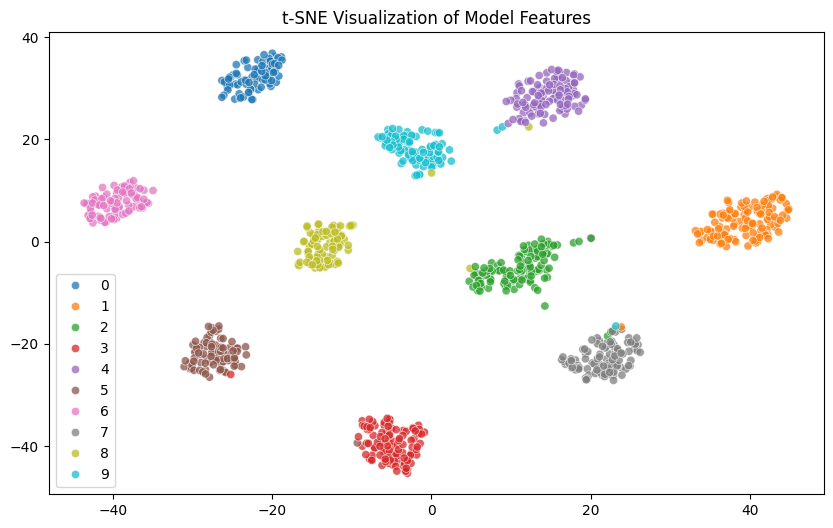

In [138]:
def visualize_tsne(model, data_loader, num_samples=1000):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, label in data_loader:
            output = model(images)
            features.append(output.numpy())
            labels.extend(label.numpy())

            if len(labels) >= num_samples:
                break

    features = np.vstack(features)[:num_samples]   #Ghép tất cả các mảng 2D trong list theo trục dọc
    labels = np.array(labels)[:num_samples]

    tsne = TSNE(n_components=2, 
                perplexity=30,    #effective number of neighbors       
                random_state=42)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette='tab10', alpha=0.75)
    plt.title('t-SNE Visualization of Model Features')
    plt.show()

visualize_tsne(cnn, test_loader)

### ResNet

In [139]:
rgb_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 3),  #Chuyển ảnh về dạng rgb 3 chiều -> phù hợp với resnet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset_rgb = datasets.MNIST(root = './data', train = True, download = False, transform = rgb_transform)
test_dataset_rgb = datasets.MNIST(root = './data', train = False, download = False,  transform = rgb_transform)

train_loader_rgb = DataLoader(train_dataset_rgb, batch_size = 64, shuffle = True)
test_loader_rgb = DataLoader(test_dataset_rgb, batch_size = 64, shuffle = True)

In [140]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

print(resnet)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:13<00:00, 3.45MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [144]:
import torch.nn.functional as F

# ======= Basic Residual Block =======
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # Hai convolution 3x3
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)

        # Downsample nếu thay đổi kích thước hoặc số kênh
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            self.down_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.down_bn(self.downsample(x))

        out += identity
        out = F.relu(out, inplace=True)
        return out


# ======= ResNet-18 Thủ Công =======
class ResNet18Manual(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # --- Stem ---
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # --- Layer 1 (64, 64) ---
        self.layer1_block1 = BasicBlock(64, 64, stride=1)
        self.layer1_block2 = BasicBlock(64, 64, stride=1)

        # --- Layer 2 (64 → 128) ---
        self.layer2_block1 = BasicBlock(64, 128, stride=2)
        self.layer2_block2 = BasicBlock(128, 128, stride=1)

        # --- Layer 3 (128 → 256) ---
        self.layer3_block1 = BasicBlock(128, 256, stride=2)
        self.layer3_block2 = BasicBlock(256, 256, stride=1)

        # --- Layer 4 (256 → 512) ---
        self.layer4_block1 = BasicBlock(256, 512, stride=2)
        self.layer4_block2 = BasicBlock(512, 512, stride=1)

        # --- Pool + FC ---
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # ---- Stem ----
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # ---- Layer 1 ----
        x = self.layer1_block1(x)
        x = self.layer1_block2(x)

        # ---- Layer 2 ----
        x = self.layer2_block1(x)
        x = self.layer2_block2(x)

        # ---- Layer 3 ----
        x = self.layer3_block1(x)
        x = self.layer3_block2(x)

        # ---- Layer 4 ----
        x = self.layer4_block1(x)
        x = self.layer4_block2(x)

        # ---- Pool & FC ----
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

resnet = ResNet18Manual()

In [145]:
def train_resnet(model, train_loader, test_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = test_loss / len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}: "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return train_losses, train_accs, test_losses, test_accs

In [ ]:
(train_losses_resnet, train_accs_resnet,
 test_losses_resnet, test_accs_resnet) = train_resnet(resnet, train_loader_rgb, test_loader_rgb)